In [124]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [439]:
img = cv2.imread('processed\\1\\0017.png', cv2.IMREAD_UNCHANGED).astype(float) / 255.0

AttributeError: 'NoneType' object has no attribute 'astype'

In [23]:
mask = np.array([
    [1./2, 1./2, 1./2],
    [1./2, 1., 1./2],
    [1./2, 1./2, 1./2]
])

In [120]:
mask = np.array([
    [0.1, 0.3, 0.5, 0.3, 0.1],
    [0.3, 0.5, 0.8, 0.5, 0.3],
    [0.5, 0.8, 1.0, 0.8, 0.5],
    [0.3, 0.5, 0.8, 0.5, 0.3],
    [0.1, 0.3, 0.5, 0.3, 0.1],
])

In [121]:
mat = np.zeros((5,5))
mat[4,4] = 1.
#mat[5,4] = 1.
mat_copy = mat.copy()

sl = lambda x, n: slice(x, n) if x >= 0 else slice(0, x)

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        offset_i = i - mask.shape[0] // 2
        offset_j = j - mask.shape[1] // 2
        if (offset_i, offset_j) == (0, 0):
            continue
        mat[sl(offset_i, mat.shape[0]), sl(offset_j, mat.shape[1])] += mat_copy[sl(-offset_i, mat.shape[0]), sl(-offset_j, mat.shape[1])] * mask[i, j]

mat

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0.3, 0.5],
       [0. , 0. , 0.3, 0.5, 0.8],
       [0. , 0. , 0.5, 0.8, 1. ]])

In [111]:
sl = lambda x, n: slice(x, n) if x >= 0 else slice(0, x)
mask[sl(0, 3), sl(-1, 3)]

array([[0.5, 0.5],
       [0.5, 1. ],
       [0.5, 0.5]])

In [84]:
mask.dot(np.array([2, 2, 2.]))

array([3., 4., 3.])

In [504]:
N = 50


def process_image(src_img):
    # монохромное изображение
    im_bw = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
    if (im_bw == 0).all():
        # исключительный случай
        im_bw = np.zeros((src_img.shape[0], src_img.shape[1]), np.uint8)
        im_bw[:, :] = (src_img.max(axis=2) > 0) * 255
    else:
        _, im_bw = cv2.threshold(im_bw, im_bw.mean(), 255, cv2.THRESH_BINARY)
        if im_bw[-1, -1] == 255:
            im_bw = cv2.bitwise_not(im_bw)

    # вырезаем символ
    def crop_image(img, threshold):
        crop_left = 0
        crop_right = 0
        crop_up = 0
        crop_down = 0
        for i in range(img.shape[1]):
            if img[:, i].sum() > threshold:
                crop_left = i
                break
        for i in reversed(range(img.shape[1])):
            if img[:, i].sum() > threshold:
                crop_right = i + 1
                break
        for i in range(img.shape[0]):
            if img[i, :].sum() > threshold:
                crop_up = i - 3
                break
        for i in reversed(range(img.shape[0])):
            if img[i, :].sum() > threshold:
                crop_down = i + 3
                break
        return img[crop_up:crop_down, crop_left:crop_right]
    cropped_img = crop_image(im_bw, 1000)

    # ресайзим до NxN
    new_size = (N * cropped_img.shape[1] // max(cropped_img.shape),
                N * cropped_img.shape[0] // max(cropped_img.shape))
    resized_img = cv2.resize(cropped_img, new_size, cv2.INTER_NEAREST)
    resized_img = (resized_img > 200) * 255

    # создаем пустое изображение размера NxN и вставляем символ по центру
    result_img = np.zeros((N, N), np.uint8)
    offset_x = (N - resized_img.shape[1]) // 2
    offset_y = (N - resized_img.shape[0]) // 2
    result_img[offset_y:offset_y + resized_img.shape[0], offset_x:offset_x + resized_img.shape[1]] = resized_img
    return result_img

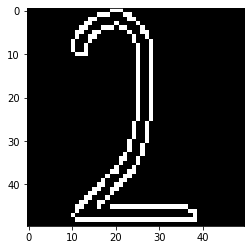

In [513]:
img = process_image(cv2.imread('predict\\2.jpg', cv2.IMREAD_UNCHANGED))
img = cv2.Canny(img, 100, 200)
plt.imshow(img, cmap='gray')

In [304]:
def create_mask(m):
    mask = np.zeros((2*m + 1, 2*m + 1))
    center = np.array([m, m])
    mask[m, m] = 1.0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            dist = np.linalg.norm(np.array([i, j]) - center) + 1.0
            mask[i, j] = 1 / (dist * dist)
    return mask

In [305]:
mask = create_mask(7)
def image_to_vector(img):
    sl = lambda x, n: slice(x, n) if x >= 0 else slice(0, x)

    result = np.zeros(img.shape)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            offset_i = i - mask.shape[0] // 2
            offset_j = j - mask.shape[1] // 2
            result[sl(offset_i, img.shape[0]), sl(offset_j, img.shape[1])] +=\
                img[sl(-offset_i, img.shape[0]), sl(-offset_j, img.shape[1])] * mask[i, j]
    return result.reshape(-1)


def load_symbol_map(dir_path):
    symbol_files = {}
    for symbol_dir in glob(f"{dir_path}*\\"):
        symbol = symbol_dir.split('\\')[-2]
        for img_file in glob(f"{symbol_dir}*"):
            if symbol not in symbol_files:
                symbol_files[symbol] = []
            symbol_files[symbol].append(img_file)

    symbol_map = {}
    for symbol, filenames in symbol_files.items():
        vectors = []
        for filename in filenames:
            img = cv2.imread(filename, cv2.IMREAD_UNCHANGED).astype(float) / 255.0
            vectors.append(image_to_vector(img))
        symbol_map[symbol] = vectors
    return symbol_map

symbol_map = load_symbol_map(f'processed_50\\')

In [281]:
def predict(symbol_map, img_vector, alpha=0.001):
    scores = []
    for symbol, symbol_vectors in symbol_map.items():
        squared_dist_vec = np.array(list(map(lambda x: np.linalg.norm(x - img_vector), symbol_vectors)))
        phi_avg = (1. / (1 + alpha * np.power(squared_dist_vec, 2.0))).mean()
        scores.append((symbol, phi_avg))
    return max(scores, key=lambda x: x[1])[0]

In [275]:
print(np.linalg.norm(symbol_map['0'][0] - symbol_map['0'][20]))
print(np.linalg.norm(symbol_map['0'][0] - symbol_map['0'][1]))
print(np.linalg.norm(symbol_map['0'][0] - symbol_map['5'][0]))

139.5132605734314
100.90710499681099
109.60588080605628


In [192]:
np.linalg.norm(symbol_map['0'][0] - symbol_map['5'][0])

61.49514434309247

In [185]:
mat = np.zeros((5,5))
mat[2,2] = 1.
#mat[4,4] = 1.
image_to_vector(mat).reshape(5,-1)

array([[0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.5       , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 1.        , 0.5       , 0.        ],
       [0.        , 0.5       , 0.5       , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [306]:
test = ['0', '1', '1_2', '2', '5', 'A', 'C', 'R', 'N', 'N_2', 'U', 'S', 'D', 'D_2']
preds = []
for symbol in test:
    pred_symbol = predict(symbol_map, image_to_vector(
        process_image(cv2.imread(f'predict\\{symbol}.jpg', cv2.IMREAD_UNCHANGED)).astype(float) / 255.0))
    preds.append((symbol, pred_symbol))
preds

[('0', '0'),
 ('1', 'J'),
 ('1_2', '1'),
 ('2', 'I'),
 ('5', 'F'),
 ('A', 'A'),
 ('C', 'F'),
 ('R', 'F'),
 ('N', '4'),
 ('N_2', 'H'),
 ('U', 'U'),
 ('S', 'I'),
 ('D', 'L'),
 ('D_2', 'D')]

In [546]:
def find_left_down_pixel(img):
    crop_left = 0
    crop_down = 0
    for i in range(img.shape[1]):
        if img[:, i].sum() > 0:
            crop_left = i
            break
    for i in reversed(range(img.shape[0])):
        if img[i, :crop_left + 1].sum() > 0:
            crop_down = i
            break
    return crop_down, crop_left

def sign(img):
    DIRECTIONS = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    sign = '('
    img_map = img > 0
    cur_pos = find_left_down_pixel(img)
    pos_lst = []
    pos_lst_set = set()
    while cur_pos:
        img_map[cur_pos] = False
        next_posistions = []
        is_first = True
        for dir_idx, direction in enumerate(DIRECTIONS):
            next_pos = (cur_pos[0] + direction[0], cur_pos[1] + direction[1])
            if not(0 <= next_pos[0] < img_map.shape[0] and 0 <= next_pos[1] < img_map.shape[1]):
                continue
            if not img_map[next_pos]:
                continue
            if not is_first and next_pos in pos_lst_set:
                continue
            #print(f'-- {next_pos}')
            next_posistions.append((next_pos, dir_idx + 1))
            pos_lst_set.add(next_pos)
            is_first = False
        if not next_posistions:
            cur_pos = None
            for next_pos, next_dir_idx in reversed(pos_lst):
                if img_map[next_pos]:
                    cur_pos = next_pos
                    sign += ')(0' + str(next_dir_idx)
                    break
        else:
            cur_pos, next_dir_idx = next_posistions.pop(0)
            pos_lst.extend(next_posistions) 
            sign += str(next_dir_idx)
        
    return sign + ')'

def normalize(sign):
    sign = sign.replace('0', '').replace('(0)', '')
    #sign = sign.replace('2', '1').replace('4', '3').replace('6', '5').replace('8', '7')
    prev_sign = ''
    while sign != prev_sign:
        prev_sign = sign
        for i in range(1, 10):
            sign = re.sub(f'{i}\d?{i}+', f'{i}', sign)
    return sign

In [462]:
normalize('22322(3)(4555555555)')

'1(3)(35)'

In [417]:
re.sub('1\d?1+', '1', '1211')

'1'

In [542]:
test_img = np.array([
    [0, 0, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0],
])
normalize(sign(test_img))

(6, 1)
-- (5, 1)
-- (7, 2)
(5, 1)
-- (4, 1)
(4, 1)
-- (3, 1)
(3, 1)
-- (2, 1)
(2, 1)
-- (1, 1)
(1, 1)
-- (0, 2)
(0, 2)
-- (0, 3)
(0, 3)
-- (1, 4)
(1, 4)
-- (2, 4)
(2, 4)
(7, 2)
-- (7, 3)
(7, 3)
-- (6, 4)
(6, 4)
-- (5, 4)
(5, 4)


'(12345)(4321)'

In [543]:
test_img = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 1, 0, 0, 0],
])
sign(test_img)

(5, 1)
-- (4, 1)
-- (4, 2)
(4, 1)
-- (3, 1)
-- (3, 2)
(3, 1)
-- (2, 2)
(2, 2)
-- (1, 2)
(1, 2)
(3, 2)
-- (4, 2)
(4, 2)


'(1121)(025)'

In [544]:
img = cv2.imread('processed_15\\2\\0002.png', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('processed_15\\2\\0011.png', cv2.IMREAD_UNCHANGED)

('(12322121211114555561)(08558161616458)(0461)(0461643343357771617716161)',
 '(14561)(816458)(461)(43571)')

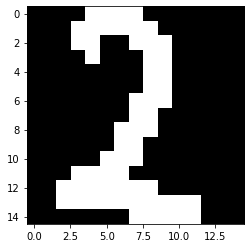

In [547]:
plt.imshow(img, cmap='gray')
sign(img), normalize(sign(img))

('(1333221211111114555555561)(085571161646161165)(045433345716177716111655716161)',
 '(13214561)(857165)(45716571)')

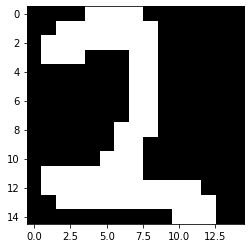

In [548]:
plt.imshow(img2, cmap='gray')
sign(img2), normalize(sign(img2))

In [398]:
img[find_left_down_pixel(img)

(43, 10)